In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from embedding import embedding_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
import pandas as pd
import numpy as np

In [3]:
books = pd.read_csv("../../dataset/books/Preprocessed_data_2.csv")

C:\Users\82104\AppData\Local\Temp\ipykernel_6352\2864897839.py:1: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("../../dataset/books/Preprocessed_data_2.csv")


In [4]:
books = books.loc[books.rating>0,:]

In [5]:
books_np = books.to_numpy()

In [6]:
books_np.shape

(352771, 16)

In [7]:
books.columns

Index(['user_id', 'age', 'location_match', 'isbn', 'year_of_publication',
       'language', 'category', 'country', 'location', 'rating', 'Unnamed: 10',
       'Language', 'value', 'Unnamed: 13', 'Category', 'Unnamed: 15'],
      dtype='object')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 isbn (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 lan (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 category (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

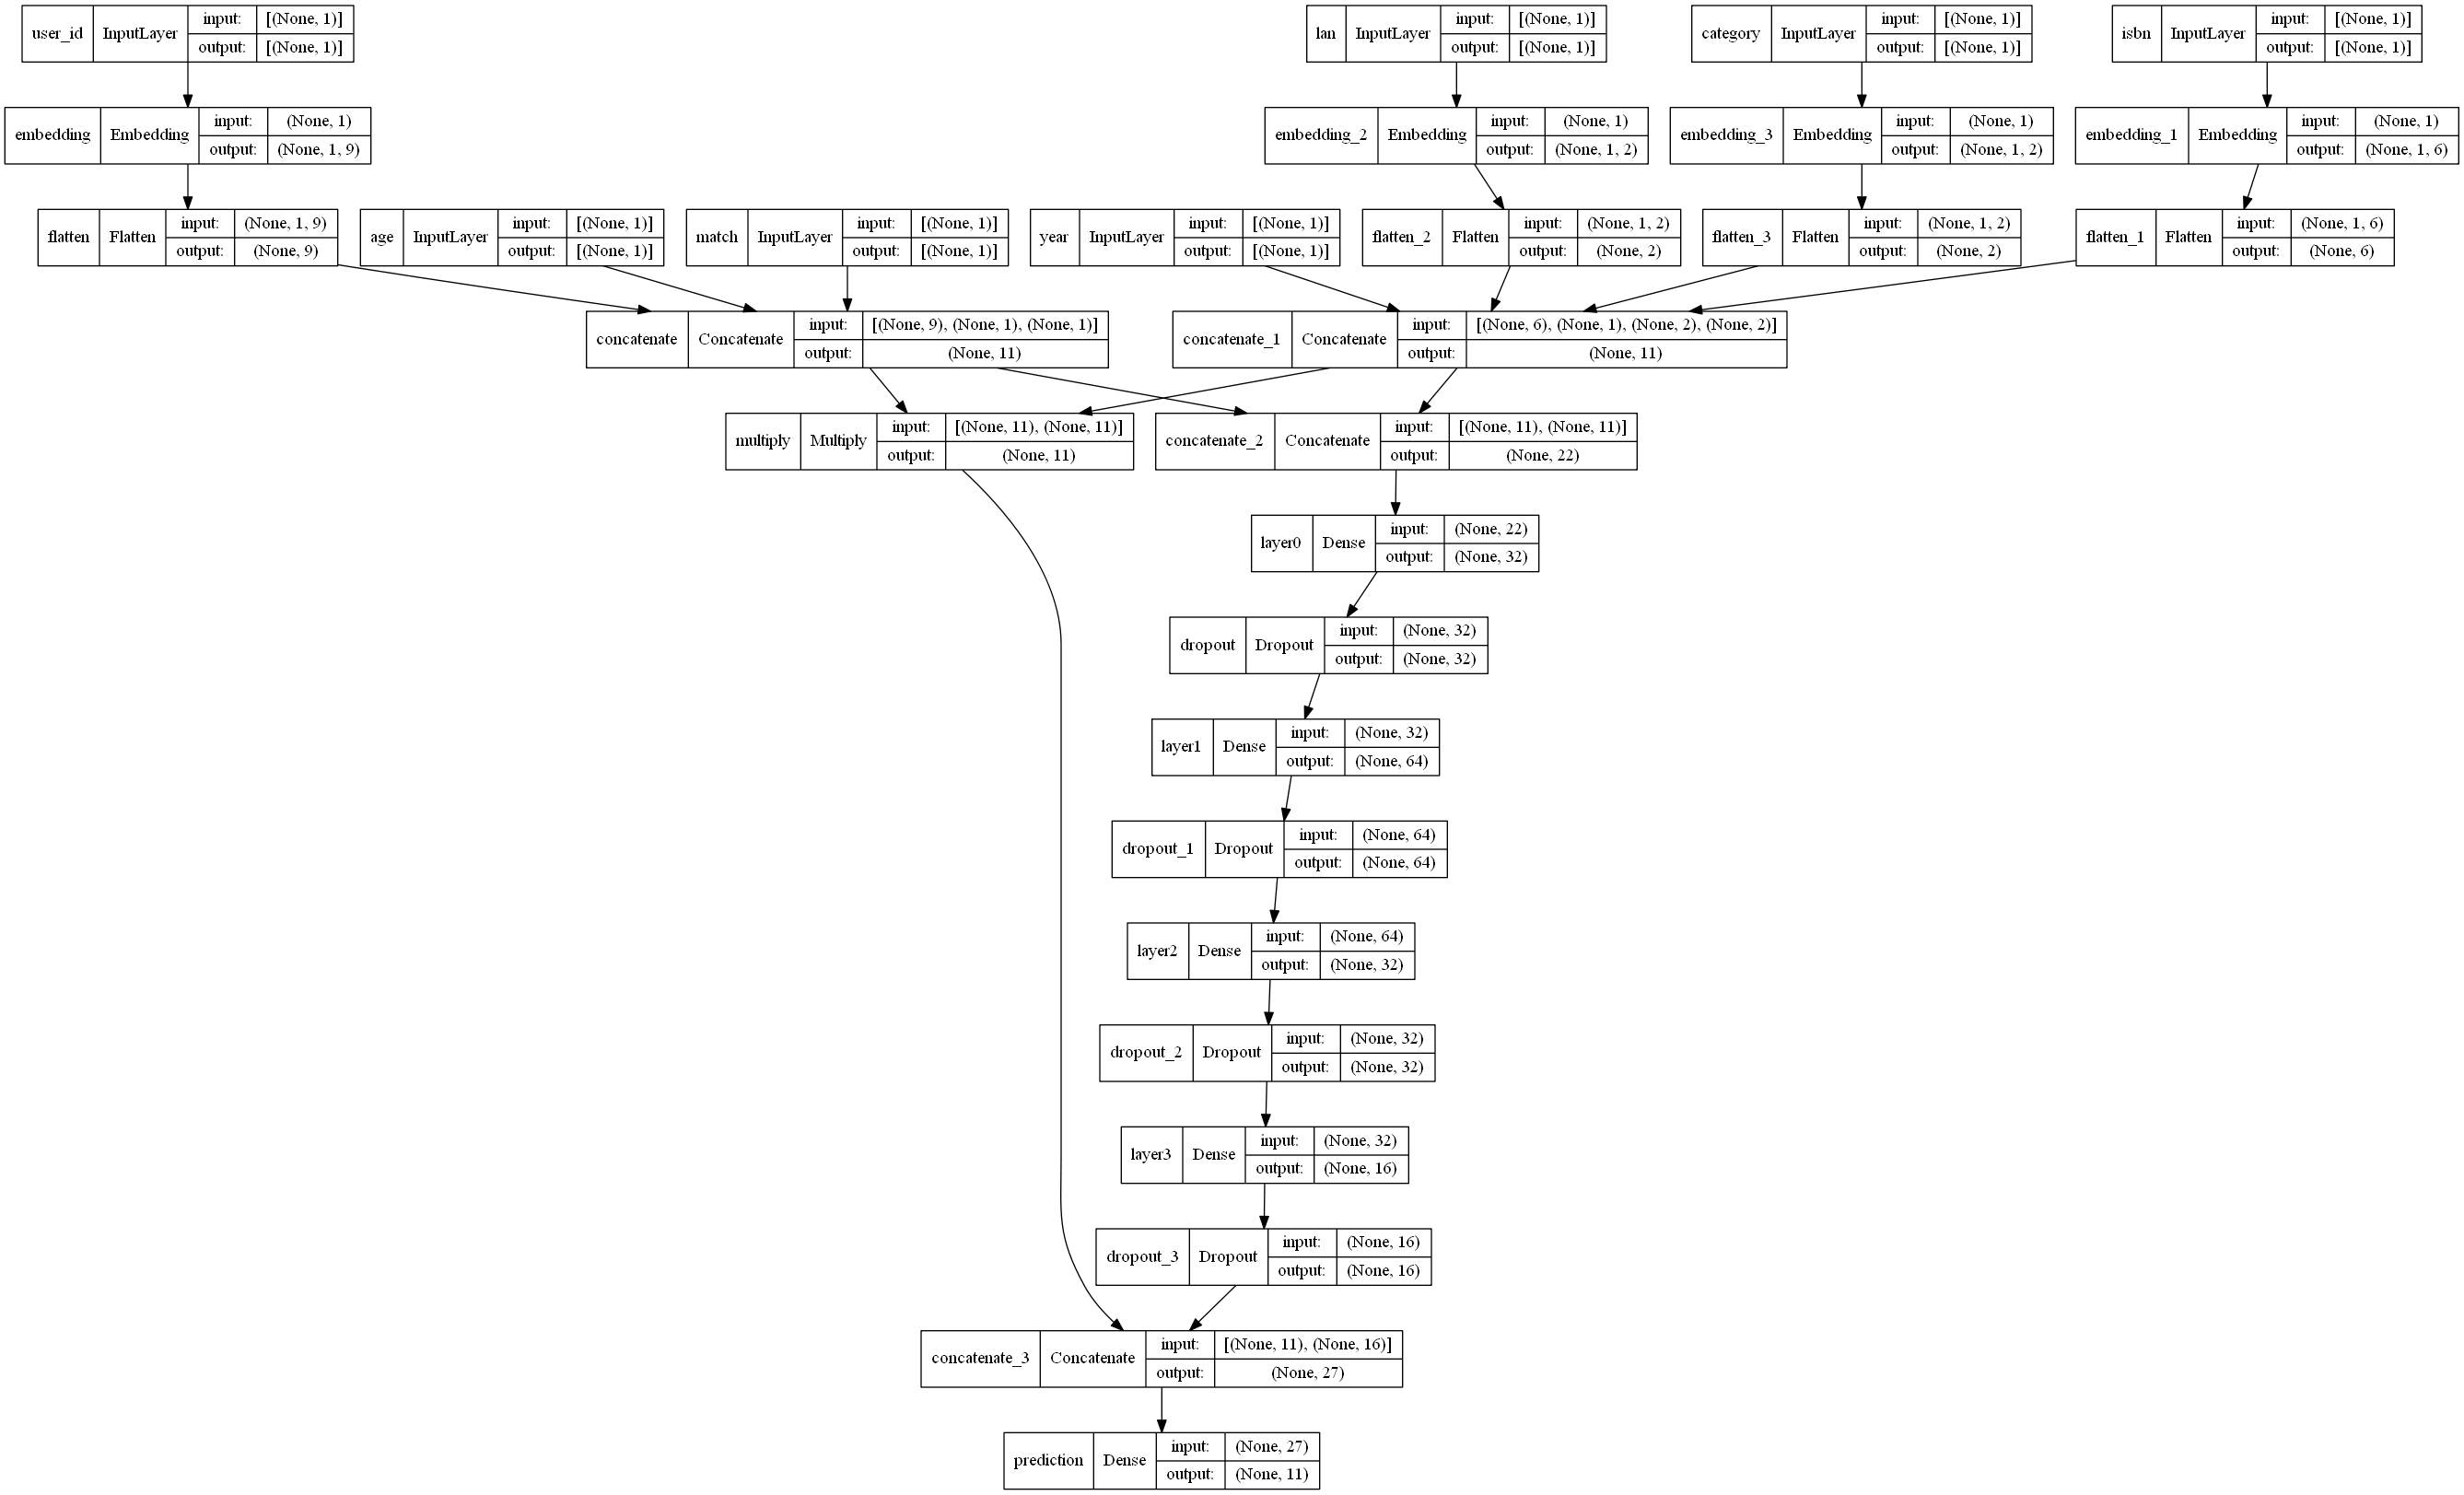

In [8]:
model = embedding_model()
model.summary()
plot_model(model, show_shapes=True)

In [9]:
dataset = books_np[:, :7].astype(float)
label = books_np[:, 9].astype(float)

In [10]:
label = to_categorical(label)

In [11]:
dataset_train, dataset_val, label_train, label_val  = train_test_split(dataset, label, test_size=0.2, random_state=2022)

In [12]:
label

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
label_train.shape

(282216, 11)

In [14]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)
lr = 0.003
loss = 'binary_crossentropy'
# loss = 'mse'
batch_size = 32768
model.compile(optimizer=Adam(learning_rate = lr), loss=loss, metrics=['mae',tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = model.fit([dataset_train[:,0],dataset_train[:,1], dataset_train[:,2], dataset_train[:,3], dataset_train[:,4], dataset_train[:,5], dataset_train[:,6]], label_train, epochs=200, batch_size = batch_size, validation_data=([dataset_val[:,0],dataset_val[:,1], dataset_val[:,2], dataset_val[:,3], dataset_val[:,4], dataset_val[:,5], dataset_val[:,6]], label_val),callbacks=[cb])

Epoch 1/200
9/9 [==============================] - 1s 36ms/step - loss: 35.2440 - recall: 0.0812 - auc: 0.4951 - val_loss: 2.3020 - val_recall: 0.0305 - val_auc: 0.4401
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 5.9774 - recall: 0.0862 - auc: 0.4988 - val_loss: 1.0296 - val_recall: 0.1333 - val_auc: 0.5651
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 2.3584 - recall: 0.0954 - auc: 0.5130 - val_loss: 0.9893 - val_recall: 0.0451 - val_auc: 0.5411
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 1.1917 - recall: 0.0693 - auc: 0.5259 - val_loss: 0.7628 - val_recall: 0.0272 - val_auc: 0.5522
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.7407 - recall: 0.0424 - auc: 0.5503 - val_loss: 0.6448 - val_recall: 0.0187 - val_auc: 0.5676
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.5590 - recall: 0.0300 - auc: 0.5743 - val_loss: 0.5657 - val_recall: 0.0152 - val_auc

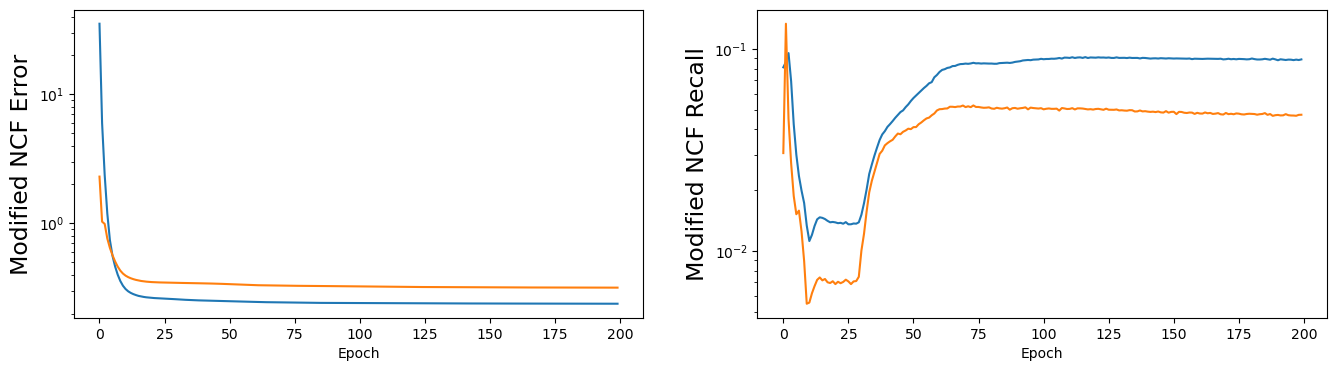

In [15]:
plt.figure(figsize=(25,4), facecolor='white')
plt.subplot(1,3,1)
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Modified NCF Error",  fontsize=17)

plt.subplot(1,3,2)
pd.Series(history.history['mae']).plot(logy=True)
pd.Series(history.history['val_mae']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Modified NCF MAE",  fontsize=17)

plt.subplot(1,3,3)
pd.Series(history.history['recall']).plot(logy=True)
pd.Series(history.history['val_recall']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Modified NCF Recall",  fontsize=17)
# plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/metrics.png")
plt.show()

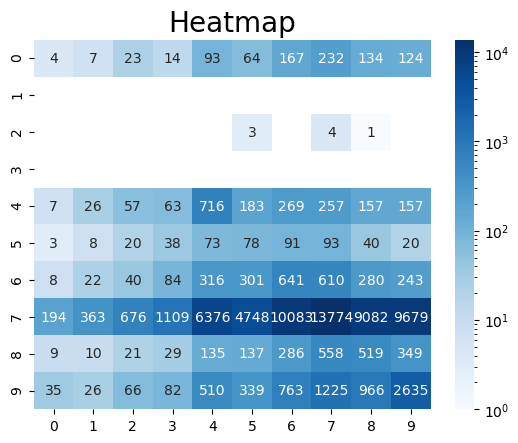

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

label_pre = model.predict([dataset_val[:,0], dataset_val[:,1], dataset_val[:,2], dataset_val[:,3], dataset_val[:,4], dataset_val[:,5], dataset_val[:,6]])

label_esti = np.argmax(label_pre,axis=1)
label_true = np.argmax(label_val,axis=1)
label_true = label_true[:,np.newaxis]
label_esti = np.round(label_esti, 0)

result = confusion_matrix(label_esti, label_true)

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
plt.figure(facecolor='white')
ax = sns.heatmap(result, annot=True,fmt='d',cmap='Blues',norm=LogNorm())
plt.title('Heatmap', fontsize=20)
# plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/heatmap.png")
plt.show()

In [17]:
label_esti

array([8, 8, 8, ..., 8, 8, 8], dtype=int64)